# Preprocessing — Overview

1. Setup — imports & environment
2. Database — load `historical_posts` and `historical_comments` from Oracle
3. Load tickers — load and normalize ticker list (NASDAQ + NYSE)
4. Data harmonization <br>
   4.1 Unify schema into `df_unified`<br>
   4.2 Placeholder-only rows analysis<br>
   4.3 Remove [removed]/[deleted] placeholders<br>
   4.4 Merge `title` + `body` for posts into `text`<br>
5. EDA — overview, missingness, text length, temporal analysis <br>
   5.1 Data types & schema overview<br>
   5.2 Column value distributions<br>
   5.3 Overview — counts & missingness<br>
   5.4 Text characteristics — word count histograms<br>
   5.5 Temporal analysis — day/hour distribution<br>
   5.6 Engagement metrics — upvote ratio<br>
   5.7 Integrity and duplicates — ID uniqueness<br>
6. Data Cleaning — remove invalid/empty records, deduplicate, drop unnecessary columns
7. Feature engineering — text_length, word_count, temporal features, engagement features, normalized_score
8. Ticker detection <br>
   8.1 Detect `mentioned_tickers`, `n_tickers`<br>
   8.2 Filter false positive tickers using stopwords<br>
   8.3 Ticker inheritance — inherit parent post tickers to comments<br>
   8.4 Inheritance success check<br>
   8.5 Data Type Conversion<br>
9. Text normalization — lowercase, remove URLs/punctuation, stopword removal
10. Export — convert mentioned_tickers to CSV-friendly string, export `preprocessed_data.csv`
11. Database Export — save to Oracle table `preprocessed_data`

**Output:** `preprocessed_data.csv` + Oracle table `preprocessed_data`

**Reddit API documentation (column descriptions):** https://praw.readthedocs.io/en/stable/code_overview/models/submission.html

**Recommended:** Install Data Wrangler extension by Microsoft for VS Code. It provides data quality metrics and lets you view/refresh DataFrames as you process data.

**Tip:** Use the OUTLINE view in the left sidebar for easy navigation through this notebook.

**Most functions are defined in `utils.py` and imported here.**

**ENJOY THE RUN**

## 1 Setup — Imports & environment

Načteme potřebné knihovny a ověříme dostupnost spaCy/NLTK a DB driveru. To nám řekne, které nástroje můžeme použít dál pro čištění a tokenizaci textu.

In [1]:
# 1. Setup: Imports and Configuration

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import os
import re
import time
from datetime import datetime
from typing import List, Set, Dict, Any
from tqdm import tqdm
from io import StringIO
import urllib.request
import urllib.parse

# Environment and database imports
try:
    from dotenv import load_dotenv
    load_dotenv()
    DOTENV_AVAILABLE = True
except ImportError:
    DOTENV_AVAILABLE = False

try:
    import oracledb
    ORACLE_AVAILABLE = True
except ImportError:
    ORACLE_AVAILABLE = False
    print("Oracle DB not available. Install with: pip install oracledb")

# Checking for NLP libraries
available_libs = []
try:
    import nltk
    NLTK_AVAILABLE = True
    available_libs.append("NLTK")

    # Check if NLTK stopwords are downloaded
    try:
        nltk.data.find('corpora/stopwords')
        print("NLTK stopwords data found")
    except LookupError:
        print("NLTK stopwords not found. Attempting to download...")
        try:
            nltk.download('stopwords', quiet=True)
            print("NLTK stopwords downloaded successfully")
        except Exception as e:
            print(f"Failed to download NLTK stopwords: {e}")
            print("   Will use fallback stopword list")
except ImportError:
    NLTK_AVAILABLE = False

try:
    import spacy
    SPACY_AVAILABLE = True
    available_libs.append("spaCy")

    # Check if spaCy model is available
    try:
        spacy.load("en_core_web_sm")
        print("spaCy 'en_core_web_sm' model found")
    except OSError:
        print("spaCy model 'en_core_web_sm' not found")
        print("   Install with: python -m spacy download en_core_web_sm")
        print("   Will fall back to NLTK if available")
except ImportError:
    SPACY_AVAILABLE = False

# Import functions from utils
from utils import (
    get_oracle_connection,
    get_all_us_tickers,
    detect_tickers_in_text,
    apply_ticker_detection,
    load_ticker_stopwords,
    apply_ticker_stopword_filter,
    harmonize_schema,
    drop_invalid_texts,
    deduplicate_and_normalize_types,
    add_temporal_features,
    add_engagement_features,
    apply_text_normalization,
    remove_financial_stopwords,
    remove_stopwords_spacy
)

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger(__name__)

# Configuration constants
MIN_TEXT_LENGTH = 10
RETRY_DELAY = 10

print(f"Step 1: imports loaded — available: {', '.join(available_libs) if available_libs else 'none'}")

NLTK stopwords data found
spaCy 'en_core_web_sm' model found
spaCy 'en_core_web_sm' model found


INFO:utils:spaCy model loaded successfully


Step 1: imports loaded — available: NLTK, spaCy


## 2 Database — Load Posts & Comments

Connect to Oracle database and load posts and comments from `historical_posts` and `historical_comments` tables.

In [2]:
# 2. Database Connection: Loading Reddit Data from Oracle

print("Step 2: importing Reddit data from Oracle database")

# Check if Oracle DB is available and credentials are set in environment variables
oracle_credentials_available = (
    ORACLE_AVAILABLE and
    os.getenv('db-username') and
    os.getenv('db-password') and
    os.getenv('db-dsn')
)

if oracle_credentials_available:
    print("Oracle credentials found")

    conn = get_oracle_connection()

    if conn:
        print("Database connection successful")

        # Importing data from database
        try:
            query_posts = """
                SELECT
                    author, title, created_utc, id, is_original_content,
                    score, DBMS_LOB.SUBSTR(body, 4000, 1) as body,
                    subreddit, upvote_ratio, url
                FROM historical_posts
                ORDER BY created_utc DESC
                FETCH FIRST 25000 ROWS ONLY
            """
            df_posts = pd.read_sql_query(query_posts, conn)

            query_comments = """
                SELECT
                    author, created_utc, id, parent_post_id, score,
                    DBMS_LOB.SUBSTR(body, 4000, 1) as body,
                    subreddit
                FROM historical_comments
                ORDER BY created_utc DESC
                FETCH FIRST 25000 ROWS ONLY
            """
            df_comments = pd.read_sql_query(query_comments, conn)

            # Closing connection immediately after data import so that it does not stay open longer than needed
            conn.close()

            print(f"\nPosts imported: {df_posts.shape}")
            print(f"Comments imported: {df_comments.shape}")

            if len(df_posts) > 0:
                print(f"Posts columns: {list(df_posts.columns)}")

            if len(df_comments) > 0:
                print(f"Comments columns: {list(df_comments.columns)}")

        except Exception as e:
            print(f"Error importing data from database: {e}")
            if conn:
                try:
                    conn.close()
                except:
                    pass
            df_posts = pd.DataFrame()
            df_comments = pd.DataFrame()

    else:
        print("Failed to connect to database - check logs.")
        df_posts = pd.DataFrame()
        df_comments = pd.DataFrame()

else:
    print("Oracle database credentials not configured — set them in .env file or environment variables")
    df_posts = pd.DataFrame()
    df_comments = pd.DataFrame()

print(f"\nStep 2 complete: Loaded {len(df_posts)} posts and {len(df_comments)} comments.")

Step 2: importing Reddit data from Oracle database
Oracle credentials found
Oracle connection successful!
Database connection successful
Oracle connection successful!
Database connection successful


/var/folders/33/r5z8ht2928103xc7s_sb_xx80000gq/T/ipykernel_65242/3346175412.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_posts = pd.read_sql_query(query_posts, conn)
/var/folders/33/r5z8ht2928103xc7s_sb_xx80000gq/T/ipykernel_65242/3346175412.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_comments = pd.read_sql_query(query_comments, conn)
/var/folders/33/r5z8ht2928103xc7s_sb_xx80000gq/T/ipykernel_65242/3346175412.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_comments = pd.read_sql_query(query_co


Posts imported: (25000, 10)
Comments imported: (25000, 7)
Posts columns: ['AUTHOR', 'TITLE', 'CREATED_UTC', 'ID', 'IS_ORIGINAL_CONTENT', 'SCORE', 'BODY', 'SUBREDDIT', 'UPVOTE_RATIO', 'URL']
Comments columns: ['AUTHOR', 'CREATED_UTC', 'ID', 'PARENT_POST_ID', 'SCORE', 'BODY', 'SUBREDDIT']

Step 2 complete: Loaded 25000 posts and 25000 comments.


## 3 Load Tickers — US Stock Ticker List

Load and normalize ticker list from NASDAQ and NYSE. Check ticker distribution by exchange.

In [3]:
# 3. Ticker Data Loading: Fetch NASDAQ/NYSE Symbols
us_tickers_path = "us_tickers.csv"

if os.path.exists(us_tickers_path):
    try:
        tickers_df = pd.read_csv(us_tickers_path, dtype=str)
        tickers_df.columns = [c.strip().lower().replace(" ", "_") for c in tickers_df.columns]
        if 'ticker' in tickers_df.columns:
            tickers_df['ticker'] = tickers_df['ticker'].astype(str).str.upper().str.strip()
        print(f"Loaded {len(tickers_df)} cached tickers")
    except Exception as e:
        print(f"Error loading cached data: {e}")
        tickers_df = None
else:
    tickers_df = None

# If no cached data or fresh data
if tickers_df is None or len(tickers_df) == 0:
    try:
        tickers_df = get_all_us_tickers()
        if len(tickers_df) > 0:
            tickers_df.to_csv(us_tickers_path, index=False)
            print(f"Fetched and cached {len(tickers_df)} US tickers")
        else:
            print("No ticker data retrieved.")
    except Exception as e:
        print(f"Error fetching ticker data: {e}")
        tickers_df = pd.DataFrame()

if len(tickers_df) > 0:
    print(f"  Exchanges: {tickers_df['exchange'].value_counts().to_dict()}")

else:
    print("No ticker data available")

print(f"\nStep 3 complete: Loaded {len(tickers_df)} ticker symbols. Letzgoo")

Loaded 8003 cached tickers
  Exchanges: {'NASDAQ': 5118, 'NYSE': 2885}

Step 3 complete: Loaded 8003 ticker symbols. Letzgoo


## 4 Data Harmonization — Unify Posts & Comments

Merge posts and comments into one `df_unified` with consistent columns (id, text, type, parent_post_id, etc.).

### 4.1 Unify Posts & Comments

Merge **df_posts** and **df_comments**, remap column names, and create unified `text` column. Columns that exist only for posts (or only for comments) will have NAs in the other type—this is expected.

In [4]:
# 4. Data Harmonization: Merge Posts and Comments

if len(df_posts) > 0 or len(df_comments) > 0:
    # combining data
    df_unified = harmonize_schema(df_posts, df_comments)
    print(f"Unified dataframe shape: {df_unified.shape}")
    print(f"Unified columns: {list(df_unified.columns)}")

    # data type distribution
    type_counts = df_unified['type'].value_counts()
    print(f"\nData distribution:")
    for dtype, count in type_counts.items():
        print(f"  {dtype}: {count} rows")

else:
    print("No data to harmonize")
    df_unified = pd.DataFrame()

print(f"\nStep 4.1 complete: Unified {len(df_unified)} rows. Letzgoo")

/Users/simon2/Library/CloudStorage/OneDrive-Personal/UČENÍ/Textová analytika 2/stock-sentiment-analysis/utils.py:293: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  unified = pd.concat([posts, comments], ignore_index=True, sort=False)
INFO:utils:Harmonized schema. Unified dataframe shape: (50000, 12)


Unified dataframe shape: (50000, 12)
Unified columns: ['author', 'title', 'created_utc', 'id', 'is_original_content', 'score', 'text', 'subreddit', 'upvote_ratio', 'url', 'parent_post_id', 'type']

Data distribution:
  post: 25000 rows
  comment: 25000 rows

Step 4.1 complete: Unified 50000 rows. Letzgoo


### 4.2 Placeholder-Only Rows Analysis

Some rows contain only placeholders ([removed]/[deleted]) with no actual content. These will be removed in the next step. Analyze how many such rows exist and their distribution by type.

In [5]:
if len(df_unified) == 0:
    print("No data")
else:
    def is_placeholder(s):
        if pd.isna(s):
            return True
        s = str(s).strip().lower()
        return s == '' or s in {'[deleted]', '[removed]', 'nan'}

    text_placeholder = df_unified['text'].apply(is_placeholder)
    title_placeholder = df_unified.get('title', pd.Series(False, index=df_unified.index)).apply(is_placeholder)

    to_drop_mask = (
        ((df_unified['type'] == 'post') & title_placeholder & text_placeholder) |
        ((df_unified['type'] == 'comment') & text_placeholder)
    )

    if to_drop_mask.any():
        print("\nPlaceholder-Only Rows by Type:")

        for t, grp in df_unified[to_drop_mask].groupby('type'):
            print(f"  {t.upper()}: {len(grp):,} rows will be deleted")

            if t == 'post':
                for col in ['title', 'text']:
                    removed = (grp[col].str.strip().str.lower() == '[removed]').sum()
                    deleted = (grp[col].str.strip().str.lower() == '[deleted]').sum()
                    print(f"    {col}: [removed]={removed:,}, [deleted]={deleted:,}")
            else:
                txt = grp['text'].astype(str).str.strip().str.lower()
                removed = (txt == '[removed]').sum()
                deleted = (txt == '[deleted]').sum()
                empty = (txt == '').sum()
                print(f"    text: [removed]={removed:,}, [deleted]={deleted:,}, empty/NA={empty:,}")
    else:
        print("No placeholder-only rows found.")


Placeholder-Only Rows by Type:
  COMMENT: 890 rows will be deleted
    text: [removed]=828, [deleted]=62, empty/NA=0


**Analysis shows placeholder-only rows are mostly comments (usually [removed]). These represent ~1% of data and will be deleted in the next step.**

### 4.3 Remove [removed]/[deleted] Placeholders

Replace [removed]/[deleted] placeholders with empty strings to avoid issues during feature engineering (e.g., "Title text. [removed]").

In [6]:
# Define placeholder checker
def is_placeholder(s):
    if pd.isna(s):
        return True
    s = str(s).strip().lower()
    return s == '' or s in {'[deleted]', '[removed]', 'nan'}

# turning placeholders into empty string
if 'title' in df_unified.columns:
    df_unified['title'] = df_unified['title'].apply(lambda x: '' if is_placeholder(x) else str(x).strip())
if 'text' in df_unified.columns:
    df_unified['text'] = df_unified['text'].apply(lambda x: '' if is_placeholder(x) else str(x).strip())

# Dropping posts where both title and text are empty after cleaning
before = len(df_unified)

# Create masks for empty posts and comments
if 'title' in df_unified.columns:
    mask_empty_post = (df_unified['type'] == 'post') & (df_unified['title'].astype(str).str.strip() == '') & (df_unified['text'].astype(str).str.strip() == '')
else:
    mask_empty_post = (df_unified['type'] == 'post') & (df_unified['text'].astype(str).str.strip() == '')

mask_empty_comment = (df_unified['type'] == 'comment') & (df_unified['text'].astype(str).str.strip() == '')

# For comments we will drop those with empty body. For posts we will drop only if both title+text empty
to_drop = mask_empty_post | mask_empty_comment
df_unified = df_unified[~to_drop].reset_index(drop=True)
after = len(df_unified)
print(f"We removed {before - after} placeholder-only rows (kept posts with title if present).")

We removed 890 placeholder-only rows (kept posts with title if present).


### 4.4 Merge Title + Body for Posts into `text` Column

For posts, merge `title` with body text. Titles often contain key information or ticker mentions. After merging, drop the `title` column (ticker detection will use the merged `text` column).

In [7]:
# 4.4 Enhanced Text: Merge Title + Body for Posts

if len(df_unified) > 0:

    # For posts: concatenate title + body
    # For comments: keep body only (no title)
    def create_enhanced_text(row):
        if row['type'] == 'post':
            title = str(row.get('title', '')).strip()
            body = str(row.get('text', '')).strip()
            # Combine title and body with separator
            if title and title != 'nan' and body and body != 'nan':
                return f"{title}. {body}"
            elif title and title != 'nan':
                return title
            elif body and body != 'nan':
                return body
            else:
                return ''
        else:
            # Comments: use text only
            return str(row.get('text', '')).strip()

    df_unified['enhanced_text'] = df_unified.apply(create_enhanced_text, axis=1)

    # Replace 'text' column with enhanced version
    df_unified['text'] = df_unified['enhanced_text']
    df_unified.drop(columns=['enhanced_text'], inplace=True)

    # We can safely drop title column since it's now merged into text (and later ticker detection is done on the "text" column)
    if 'title' in df_unified.columns:
        df_unified.drop(columns=['title'], inplace=True)
        print("Dropped 'title' column (merged into 'text')")

    print(f"Done")

else:
    print("No data to enhance")

Dropped 'title' column (merged into 'text')
Done


## 5 Exploratory Data Analysis (EDA)

Projdeme kvalitu dat a základní statistiky, abychom věděli jak data dál (pokud je to potřeba) upravit.

### 5.1 Data Types Check & Schema Overview

Check and convert data types for all columns. This ensures correct data processing in subsequent steps.

In [8]:
# 5.1 Data types check

if len(df_unified) > 0:
    print(f"Dataset shape: {df_unified.shape}")

    for col in df_unified.columns:
        dtype = df_unified[col].dtype
        print(f"  {col:20} : {str(dtype):15}")

else:
    print("No data available")

Dataset shape: (49110, 11)
  author               : object         
  created_utc          : int64          
  id                   : object         
  is_original_content  : object         
  score                : int64          
  text                 : object         
  subreddit            : object         
  upvote_ratio         : float64        
  url                  : object         
  parent_post_id       : object         
  type                 : object         


**Convert to correct data types:**

In [9]:
# DateTime conversion
if 'created_utc' in df_unified.columns:
    df_unified['created_utc'] = pd.to_datetime(df_unified['created_utc'], unit='s', errors='coerce')

# Numeric conversions
numeric_cols = {'score': 'float64', 'upvote_ratio': 'float64'}
for col, dtype in numeric_cols.items():
    df_unified[col] = pd.to_numeric(df_unified[col], errors='coerce').astype(dtype)


# Categorical conversions
for col in ['type', 'subreddit']:
    df_unified[col] = df_unified[col].astype('category')

# String conversions
for col in ['id', 'text', 'author', 'url']:
    df_unified[col] = df_unified[col].astype(pd.StringDtype())

# Handle parent_post_id (preserve NaN)
if 'parent_post_id' in df_unified.columns:
    df_unified['parent_post_id'] = df_unified['parent_post_id'].astype(pd.StringDtype())

# Drop constant column
if 'is_original_content' in df_unified.columns:
    df_unified.drop(columns=['is_original_content'], inplace=True)

print(f"Data types after conversion:")
for col in df_unified.columns:
    dtype = df_unified[col].dtype
    non_null = df_unified[col].notna().sum()
    print(f"{col} : {str(dtype)}")

Data types after conversion:
author : string
created_utc : datetime64[ns]
id : string
score : float64
text : string
subreddit : category
upvote_ratio : float64
url : string
parent_post_id : string
type : category


### 5.2 Column value distributions

Prozkoumáme rozložení hodnot ve sloupcích - počty unikátních hodnot, konstantní sloupce a základní distribuce kategorických proměnných.

In [10]:
# 5.2 Column Value Distributions

if len(df_unified) > 0:
    print("\nUnique Value Counts:")

    for col in df_unified.columns:
        n_unique = df_unified[col].nunique()
        n_total = len(df_unified)
        pct_unique = (n_unique / n_total) * 100

        print(f"  {col:20} : {n_unique:,} unique values ({pct_unique:.1f}% of total)")

    print(f"\nStep 5.2 completed")

else:
    print("No data available")


Unique Value Counts:
  author               : 24,641 unique values (50.2% of total)
  created_utc          : 48,031 unique values (97.8% of total)
  id                   : 49,110 unique values (100.0% of total)
  score                : 491 unique values (1.0% of total)
  text                 : 46,721 unique values (95.1% of total)
  subreddit            : 5 unique values (0.0% of total)
  upvote_ratio         : 98 unique values (0.2% of total)
  url                  : 24,752 unique values (50.4% of total)
  parent_post_id       : 1,820 unique values (3.7% of total)
  type                 : 2 unique values (0.0% of total)

Step 5.2 completed


**[is_original_content] has only value 0 (constant), so it will be dropped. No other data quality issues detected.**

### 5.3 Overview — counts & missingness 

Spočítáme počty, podíly chybějících hodnot a zjistíme, kolik záznamů je smazaných nebo prázdných (NAs).

In [11]:
# 5.3 Data Quality & Completeness
if len(df_unified) > 0:

    print("\nNAs by Column:")
    for col in df_unified.columns:
        missing_count = df_unified[col].isna().sum()
        if missing_count > 0:
            missing_pct = (missing_count / len(df_unified)) * 100
            print(f"  {col}: {missing_count:,} ({missing_pct:.1f}%)")

else:
    print("No data available for quality analysis.")


NAs by Column:
  upvote_ratio: 24,110 (49.1%)
  url: 24,318 (49.5%)
  parent_post_id: 25,000 (50.9%)


Missing values in [is_original_content], [upvote_ratio], [url], [parent_post_id] are structural (posts vs. comments have different columns). In data cleaning, we'll drop is_original_content and url. **[parent_post_id] must be kept for ticker inheritance.**

Very short texts (≤10 chars) will be removed in Step 6.

### 5.4 Text Characteristics

Analyze text lengths, word counts, and percentiles to identify very short texts for removal.


Word Count Statistics (Overall):
  Mean: 53.4 words
  Median: 17.0 words
  Min: 1 words
  Max: 794 words


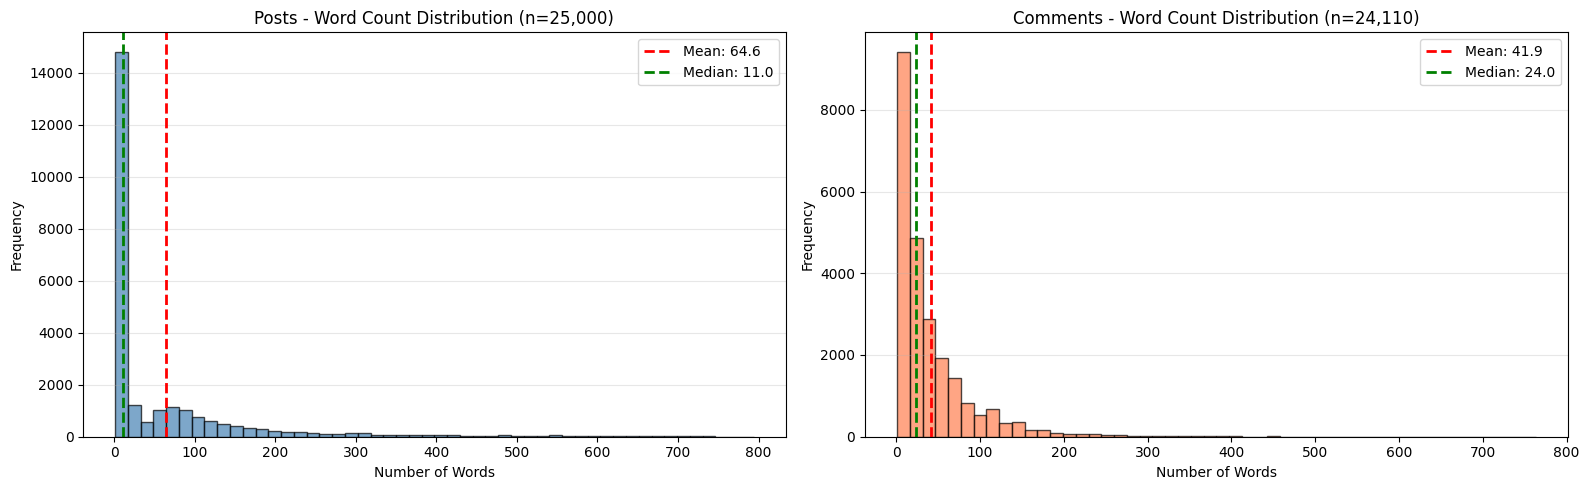


Quality Issues:
  Texts ≤10 chars: 1,189 (2.4%)


In [12]:
# 5.4 Text Characteristics

if len(df_unified) > 0 and 'text' in df_unified.columns:

    # Calculating text statistics
    valid_texts = df_unified[df_unified['text'].notna() & (df_unified['text'] != '')]

    if len(valid_texts) > 0:
        text_lengths = valid_texts['text'].astype(str).str.len()

        word_counts = valid_texts['text'].astype(str).str.split().str.len()

        print(f"\nWord Count Statistics (Overall):")
        print(f"  Mean: {word_counts.mean():.1f} words")
        print(f"  Median: {word_counts.median():.1f} words")
        print(f"  Min: {word_counts.min()} words")
        print(f"  Max: {word_counts.max()} words")

        if 'type' in valid_texts.columns:
            posts = valid_texts[valid_texts['type'] == 'post']
            comments = valid_texts[valid_texts['type'] == 'comment']

            if len(posts) > 0 and len(comments) > 0:
                post_word_counts = posts['text'].astype(str).str.split().str.len()
                comment_word_counts = comments['text'].astype(str).str.split().str.len()

                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

                # Posts
                ax1.hist(post_word_counts, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
                ax1.axvline(post_word_counts.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {post_word_counts.mean():.1f}')
                ax1.axvline(post_word_counts.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {post_word_counts.median():.1f}')
                ax1.set_xlabel('Number of Words')
                ax1.set_ylabel('Frequency')
                ax1.set_title(f'Posts - Word Count Distribution (n={len(posts):,})')
                ax1.legend()
                ax1.grid(axis='y', alpha=0.3)

                # Comments
                ax2.hist(comment_word_counts, bins=50, edgecolor='black', alpha=0.7, color='coral')
                ax2.axvline(comment_word_counts.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {comment_word_counts.mean():.1f}')
                ax2.axvline(comment_word_counts.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {comment_word_counts.median():.1f}')
                ax2.set_xlabel('Number of Words')
                ax2.set_ylabel('Frequency')
                ax2.set_title(f'Comments - Word Count Distribution (n={len(comments):,})')
                ax2.legend()
                ax2.grid(axis='y', alpha=0.3)

                plt.tight_layout()
                plt.show()
            else:
                print("  Not enough data for separate histograms")

        # Short texts identification
        very_short = (text_lengths <= MIN_TEXT_LENGTH).sum()
        print(f"\nQuality Issues:")
        print(f"  Texts ≤{MIN_TEXT_LENGTH} chars: {very_short:,} ({very_short/len(valid_texts)*100:.1f}%)")

else:
    print("No text data")

**Distribution looks reasonable. Posts are longer than comments on average. For sentiment analysis, there's no concept of "outlier" in word count—all lengths are valid.**

### 5.5 Temporal Analysis

Analyze temporal distribution of posts/comments (daily/hourly patterns and date range).


Date Range:
  Earliest: 2024-10-10 20:19:47
  Latest: 2024-12-31 23:59:56
  Span: 82 days
  Mean posts per day: 591.7

Temporal Distribution Charts:


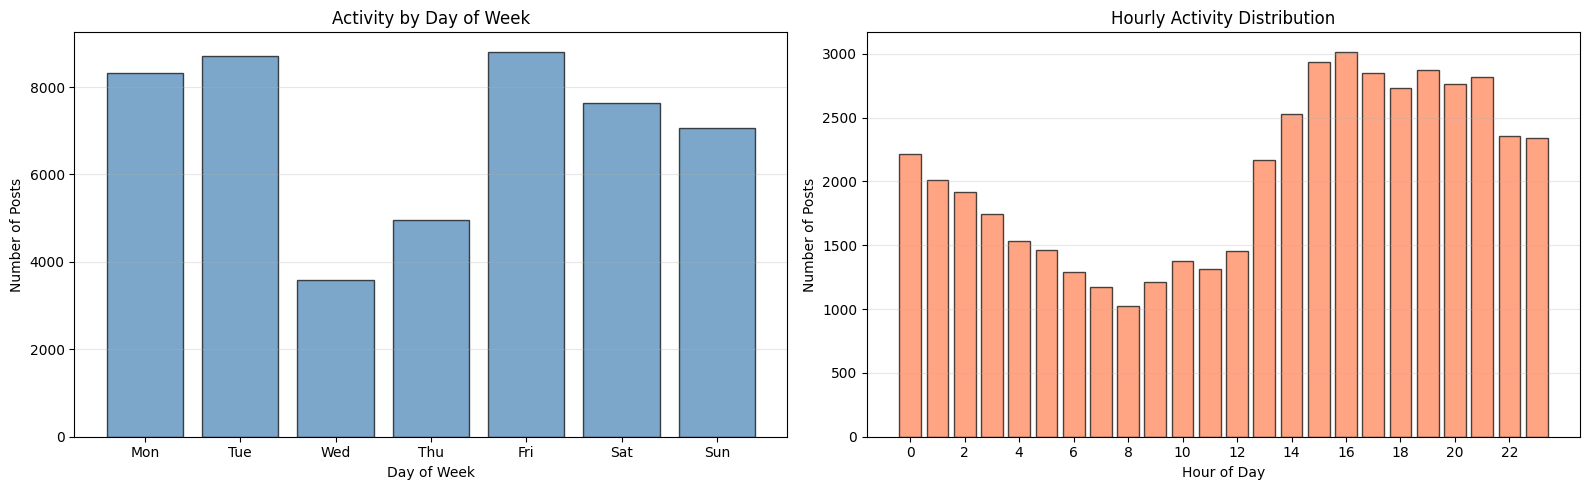

In [13]:
# 5.5 Temporal Analysis

if len(df_unified) > 0 and 'created_utc' in df_unified.columns:

    # Converting to datetime
    valid_dates = df_unified[df_unified['created_utc'].notna()].copy()

    if len(valid_dates) > 0:
        valid_dates['datetime'] = pd.to_datetime(valid_dates['created_utc'], unit='s')

        # Date range
        print(f"\nDate Range:")
        print(f"  Earliest: {valid_dates['datetime'].min()}")
        print(f"  Latest: {valid_dates['datetime'].max()}")
        print(f"  Span: {(valid_dates['datetime'].max() - valid_dates['datetime'].min()).days} days")

        valid_dates['date'] = valid_dates['datetime'].dt.date
        valid_dates['hour'] = valid_dates['datetime'].dt.hour
        valid_dates['day_of_week'] = valid_dates['datetime'].dt.day_name()
        valid_dates['month'] = valid_dates['datetime'].dt.month

        # Posts per day
        daily_counts = valid_dates.groupby('date').size()
        print(f"  Mean posts per day: {daily_counts.mean():.1f}")

        # temporal patterns
        print(f"\nTemporal Distribution Charts:")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        day_counts = valid_dates['day_of_week'].value_counts()
        day_counts_ordered = [int(day_counts.get(d, 0)) for d in day_order]
        ax1.bar(range(7), day_counts_ordered, color='steelblue', alpha=0.7, edgecolor='black')
        ax1.set_xlabel('Day of Week')
        ax1.set_ylabel('Number of Posts')
        ax1.set_title('Activity by Day of Week')
        ax1.set_xticks(range(7))
        ax1.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
        ax1.grid(axis='y', alpha=0.3)

        hour_counts = valid_dates['hour'].value_counts()
        hours = list(range(24))
        counts = [hour_counts.get(h, 0) for h in hours]
        ax2.bar(hours, counts, color='coral', alpha=0.7, edgecolor='black')
        ax2.set_xlabel('Hour of Day')
        ax2.set_ylabel('Number of Posts')
        ax2.set_title('Hourly Activity Distribution')
        ax2.set_xticks(range(0, 24, 2))
        ax2.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()

    print()
else:
    print("Warning: No temporal data available for analysis")

**Peak activity: Tuesday/Wednesday, afternoon/evening hours.**

### 5.6 Upvote ratio analysis

Analyzujeme upvote_ratio - poměr kladných hodnocení (upvotes / (upvotes + downvotes)). Tato metrika je dostupná pouze pro posty.

  Mean: 0.860
  Median: 1.000
  Min: 0.030
  Max: 1.000

Upvote Ratio Histogram:


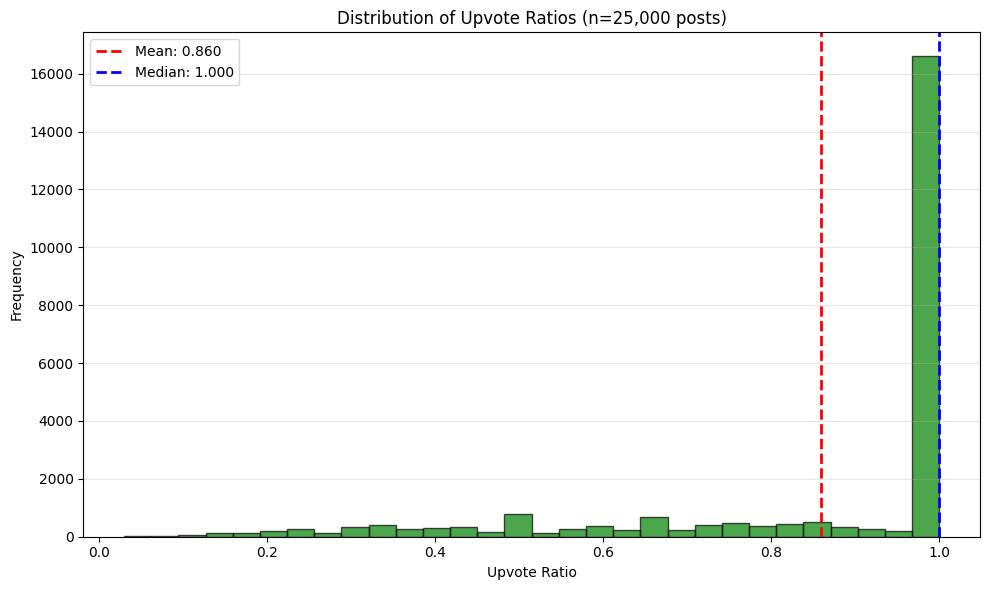

In [14]:
# 5.6 Upvote Ratio Analysis

if len(df_unified) > 0:
    if 'upvote_ratio' in df_unified.columns:
        posts = df_unified[df_unified['type'] == 'post']

        if len(posts) > 0 and 'upvote_ratio' in posts.columns:
            upvote_ratios = posts['upvote_ratio'].dropna()

            if len(upvote_ratios) > 0:
                print(f"  Mean: {upvote_ratios.mean():.3f}")
                print(f"  Median: {upvote_ratios.median():.3f}")
                print(f"  Min: {upvote_ratios.min():.3f}")
                print(f"  Max: {upvote_ratios.max():.3f}")

            print(f"\nUpvote Ratio Histogram:")
            fig, ax = plt.subplots(1, 1, figsize=(10, 6))

            # Histogram
            ax.hist(upvote_ratios, bins=30, edgecolor='black', alpha=0.7, color='green')
            ax.axvline(upvote_ratios.mean(), color='red', linestyle='--', linewidth=2,
                        label=f'Mean: {upvote_ratios.mean():.3f}')
            ax.axvline(upvote_ratios.median(), color='blue', linestyle='--', linewidth=2,
                        label=f'Median: {upvote_ratios.median():.3f}')
            ax.set_xlabel('Upvote Ratio')
            ax.set_ylabel('Frequency')
            ax.set_title(f'Distribution of Upvote Ratios (n={len(upvote_ratios):,} posts)')
            ax.legend()
            ax.grid(axis='y', alpha=0.3)

            plt.tight_layout()
            plt.show()

else:
    print("Warning: No data available for upvote ratio analysis")

**Upvote ratio ranges 0-1, generally positive (mean ~0.9).**

### 5.7 Data Integrity & Duplicates

Check for duplicate IDs and other integrity issues (missing IDs, very short texts).

In [15]:
# 5.7 Data Integrity & Duplicates

if len(df_unified) > 0:

    # Duplicate IDs
    if 'id' in df_unified.columns:
        total_ids = len(df_unified)
        unique_ids = df_unified['id'].nunique()
        duplicate_ids = total_ids - unique_ids

        print(f"  Total rows: {total_ids:,}")
        print(f"  Unique IDs: {unique_ids:,}")
        print(f"  Duplicate IDs: {duplicate_ids:,} ({duplicate_ids/total_ids*100:.2f}%)")

        if duplicate_ids > 0:
            dup_counts = df_unified['id'].value_counts()
            most_duplicated = dup_counts[dup_counts > 1].head(5)
            print(f"\n  Most duplicated IDs:")
            for id_val, count in most_duplicated.items():
                print(f"    {id_val}: appears {count} times")

    # potential issues
    print(f"\nPotential Data Issues:")
    issues_found = 0

    critical_fields = ['id', 'text', 'created_utc']
    for field in critical_fields:
        if field in df_unified.columns:
            na_count = df_unified[field].isna().sum()
            if na_count > 0:
                print(f"  Warning {field}: {na_count:,} missing values")
                issues_found += 1

    if 'text' in df_unified.columns:
        deleted = df_unified['text'].isin(['[deleted]', '[removed]']).sum()
        if deleted > 0:
            print(f"  Warning: Deleted/removed content: {deleted:,} rows")
            issues_found += 1

    if 'text' in df_unified.columns:
        very_short = (df_unified['text'].astype(str).str.len() <= 5).sum()
        if very_short > 0:
            print(f"  Warning: Extremely short texts (≤5 chars): {very_short:,} rows")
            issues_found += 1

    if issues_found == 0:
        print("No major data quality issues detected")

else:
    print("No data available for integrity analysis")

  Total rows: 49,110
  Unique IDs: 49,110
  Duplicate IDs: 0 (0.00%)

Potential Data Issues:


## 6 Data Cleaning

Remove deleted/empty texts, handle NAs, and filter out very short records.

In [16]:
# 6. Data Cleaning: Remove Invalid and Duplicate Content

print(f"Starting with {len(df_unified)} rows")

# Step 6a: Remove invalid texts
df_cleaned = drop_invalid_texts(df_unified, min_len=MIN_TEXT_LENGTH)
print(f"    After removing invalid texts: {len(df_cleaned)} rows (-{len(df_unified) - len(df_cleaned)})")

# Step 6b: Deduplicate and normalize types
df_cleaned = deduplicate_and_normalize_types(df_cleaned)
print(f"    After deduplication: {len(df_cleaned)} rows")

# Step 6c: Dropping unnecessary columns (url, is_original_content, author)
columns_to_drop = ['url', 'is_original_content', 'author']
existing_cols_to_drop = [col for col in columns_to_drop if col in df_cleaned.columns]
if existing_cols_to_drop:
    df_cleaned.drop(columns=existing_cols_to_drop, inplace=True)
    print(f"    Dropped columns: {existing_cols_to_drop}")

# Show cleaning results
print(f"  Original rows: {len(df_unified)}")
print(f"  Cleaned rows: {len(df_cleaned)}")
print(f"  Removed: {len(df_unified) - len(df_cleaned)} ({((len(df_unified) - len(df_cleaned))/len(df_unified)*100):.1f}%)")

# Show data types after cleaning
print(f"\nData types after cleaning:")
type_counts = df_cleaned['type'].value_counts()
for dtype, count in type_counts.items():
    print(f"  {dtype}: {count} rows")

print(f"\nStep 6 complete: {len(df_cleaned)} clean rows")

Starting with 49110 rows
    After removing invalid texts: 47921 rows (-1189)
    After deduplication: 47921 rows
    Dropped columns: ['url', 'author']
  Original rows: 49110
  Cleaned rows: 47921
  Removed: 1189 (2.4%)

Data types after cleaning:
  post: 24919 rows
  comment: 23002 rows

Step 6 complete: 47921 clean rows


## 7 Feature Engineering

Add useful features: text_length, word_count, temporal features, engagement features. Create normalized_score (per subreddit, 0-1 scale). Drop original score column and upvote_ratio (only available for posts).

In [17]:
# 7. Feature Engineering: Add Temporal and Engagement Features

df_features = add_temporal_features(df_cleaned)
df_features = add_engagement_features(df_features)

# Create normalized_score per subreddit (0-1 scale)
if 'score' in df_features.columns and 'subreddit' in df_features.columns:
    df_features['normalized_score'] = df_features.groupby('subreddit')['score'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min() + 1e-6)  # +1e-6 -> to avoid division by zero)
    )

    print(f"\nPer-Subreddit Normalization Check:")
    for sub in df_features['subreddit'].unique():
        sub_data = df_features[df_features['subreddit'] == sub]
        print(f"  {sub}:")
        print(f"    Raw scores: min={sub_data['score'].min():.0f}, "
                f"max={sub_data['score'].max():.0f}, "
                f"mean={sub_data['score'].mean():.1f}")
        print(f"    Normalized: min={sub_data['normalized_score'].min():.3f}, "
                f"max={sub_data['normalized_score'].max():.3f}, "
                f"mean={sub_data['normalized_score'].mean():.3f}")

    # Drop original score column after normalization
    df_features.drop(columns=['score'], inplace=True)

# Drop upvote_ratio (only for posts, creates NAs for comments)
if 'upvote_ratio' in df_features.columns:
    df_features.drop(columns=['upvote_ratio'], inplace=True)

new_features = ['date', 'hour', 'day_of_week', 'month', 'is_weekend',
                'text_length', 'word_count', 'normalized_score']
print(f"\nNew features added: {[f for f in new_features if f in df_features.columns]}")

print(f"\nStep 7 complete: {len(df_features)} rows with enhanced features")



Per-Subreddit Normalization Check:
  investing:
    Raw scores: min=-55, max=3043, mean=5.7
    Normalized: min=0.000, max=1.000, mean=0.020
  stocks:
    Raw scores: min=-104, max=9378, mean=12.0
    Normalized: min=0.000, max=1.000, mean=0.012
  financialindependence:
    Raw scores: min=-59, max=1254, mean=7.7
    Normalized: min=0.000, max=1.000, mean=0.051
  ValueInvesting:
    Raw scores: min=-56, max=1059, mean=8.2
    Normalized: min=0.000, max=1.000, mean=0.058
  SecurityAnalysis:
    Raw scores: min=1, max=29, mean=6.4
    Normalized: min=0.000, max=1.000, mean=0.191

New features added: ['date', 'hour', 'day_of_week', 'month', 'is_weekend', 'text_length', 'word_count', 'normalized_score']

Step 7 complete: 47921 rows with enhanced features


/var/folders/33/r5z8ht2928103xc7s_sb_xx80000gq/T/ipykernel_65242/3871438954.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_features['normalized_score'] = df_features.groupby('subreddit')['score'].transform(


## 8 Ticker Detection

Detect stock tickers in text using loaded ticker list. Store detected tickers in `mentioned_tickers` and count in `n_tickers`.

### 8.1 Detect Stock Ticker Mentions

In [18]:
# 8.1 Ticker Detection: Identify Stock Ticker Mentions

print(f"Detecting tickers in {len(df_features)} texts using {len(tickers_df)} symbols")

df_with_tickers = apply_ticker_detection(df_features, tickers_df)

# results
ticker_stats = df_with_tickers['n_tickers'].value_counts().sort_index()
total_with_tickers = (df_with_tickers['n_tickers'] > 0).sum()
print(f"  Total rows: {len(df_with_tickers)}")
print(f"  Rows with tickers: {total_with_tickers} ({total_with_tickers/len(df_with_tickers)*100:.1f}%)")
print(f"  Rows without tickers: {len(df_with_tickers) - total_with_tickers}")

print(f"\nTicker count distribution:")
for count, rows in ticker_stats.head(10).items():
    print(f"  {count} tickers: {rows} rows")

print(f"\nStep 8 complete: Processed {len(df_with_tickers)} rows for ticker detection")

Detecting tickers in 47921 texts using 8003 symbols


100%|██████████| 47921/47921 [00:00<00:00, 134130.69it/s]

  Total rows: 47921
  Rows with tickers: 10131 (21.1%)
  Rows without tickers: 37790

Ticker count distribution:
  0 tickers: 37790 rows
  1 tickers: 7093 rows
  2 tickers: 1667 rows
  3 tickers: 599 rows
  4 tickers: 291 rows
  5 tickers: 130 rows
  6 tickers: 91 rows
  7 tickers: 61 rows
  8 tickers: 40 rows
  9 tickers: 30 rows

Step 8 complete: Processed 47921 rows for ticker detection


### 8.2 Filter False Positive Tickers

In [19]:
# 8.2 Filter False Positive Tickers

ticker_stopwords = load_ticker_stopwords()
before_count = df_with_tickers['n_tickers'].sum()
df_with_tickers = apply_ticker_stopword_filter(df_with_tickers, ticker_stopwords)
after_count = df_with_tickers['n_tickers'].sum()
removed = before_count - after_count

print(f"Filtered out {removed} false positive tickers ({removed/before_count*100:.1f}%)")
print(f"Remaining: {after_count} ticker mentions")
print(f"\nStep 8.2 complete")

INFO:utils:Loaded 545 ticker stopwords
INFO:utils:After stopword filtering: 8186 rows with valid tickers
INFO:utils:After stopword filtering: 8186 rows with valid tickers


Filtered out 3570 false positive tickers (19.9%)
Remaining: 14348 ticker mentions

Step 8.2 complete


### 8.3 Ticker Inheritance — Comments Inherit Parent Post Tickers

Comments inherit tickers from their parent posts (union). This improves ticker coverage for comments that discuss a post without explicitly mentioning the ticker.

In [20]:
# 8.3 Ticker Inheritance from Parent Posts
# Save "before inheritance" counts for comparison
comments_before = df_with_tickers[df_with_tickers['type'] == 'comment']
comments_with_tickers_before = (comments_before['n_tickers'] > 0).sum()

# Build map of post_id -> tickers
posts = df_with_tickers[df_with_tickers['type'] == 'post'].copy()
post_ticker_map = {}

for _, row in posts.iterrows():
    post_id = row['id']
    tickers_data = row.get('mentioned_tickers', [])
    if isinstance(tickers_data, list) and len(tickers_data) > 0:
        post_ticker_map[post_id] = set(tickers_data)

# Inheritance function: merge comment's own tickers with parent's tickers
def inherit_parent_tickers(row):
    if row['type'] == 'comment':
        parent_id = row.get('parent_post_id')
        if pd.notna(parent_id) and parent_id in post_ticker_map:
            own_tickers = set(row.get('mentioned_tickers', []))
            parent_tickers = post_ticker_map[parent_id]
            merged_tickers = own_tickers.union(parent_tickers)
            return sorted(merged_tickers)

    tickers_data = row.get('mentioned_tickers', [])
    return tickers_data if isinstance(tickers_data, list) else []

# Apply inheritance
df_with_tickers['mentioned_tickers'] = df_with_tickers.apply(inherit_parent_tickers, axis=1)
df_with_tickers['n_tickers'] = df_with_tickers['mentioned_tickers'].apply(len)

print("Step 8.3 completed")

Step 8.3 completed


### 8.4 Ticker Inheritance Impact Analysis

In [21]:
# 8.4 Ticker Inheritance Impact Analysis

posts = df_with_tickers[df_with_tickers['type'] == 'post']
comments = df_with_tickers[df_with_tickers['type'] == 'comment']

posts_with_tickers = (posts['n_tickers'] > 0).sum()
comments_with_tickers_after = (comments['n_tickers'] > 0).sum()

print(f"\nPOSTS:")
print(f"  With tickers: {posts_with_tickers} / {len(posts)} ({posts_with_tickers/len(posts)*100:.2f}%)")

print(f"\nCOMMENTS:")
print(f"  BEFORE inheritance: {comments_with_tickers_before} / {len(comments)} ({comments_with_tickers_before/len(comments)*100:.2f}%)")
print(f"  AFTER inheritance:  {comments_with_tickers_after} / {len(comments)} ({comments_with_tickers_after/len(comments)*100:.2f}%)")

print(f"\nOVERALL:")
total_with_tickers = (df_with_tickers['n_tickers'] > 0).sum()
print(f"  Total rows with tickers: {total_with_tickers} / {len(df_with_tickers)} ({total_with_tickers/len(df_with_tickers)*100:.2f}%)")

# Drop parent_post_id after inheritance is complete
if 'parent_post_id' in df_with_tickers.columns:
    df_with_tickers.drop(columns=['parent_post_id'], inplace=True)
    print(f"\nDropped 'parent_post_id' column (no longer needed)")

print("\nStep 8.4 completed")



POSTS:
  With tickers: 4985 / 24919 (20.00%)

COMMENTS:
  BEFORE inheritance: 3201 / 23002 (13.92%)
  AFTER inheritance:  8678 / 23002 (37.73%)

OVERALL:
  Total rows with tickers: 13663 / 47921 (28.51%)

Dropped 'parent_post_id' column (no longer needed)

Step 8.4 completed


### 8.5 Data Type Conversion

Ensure all columns have correct data types after feature engineering and ticker detection.

In [22]:
# 8.5 Comprehensive Data Type Conversion
# Datetime conversions
df_with_tickers['created_utc'] = pd.to_datetime(df_with_tickers['created_utc'])
df_with_tickers['date'] = pd.to_datetime(df_with_tickers['date'])

# Integer conversions
df_with_tickers['hour'] = df_with_tickers['hour'].astype('int8')
df_with_tickers['month'] = df_with_tickers['month'].astype('int8')
df_with_tickers['text_length'] = df_with_tickers['text_length'].astype('int32')
df_with_tickers['word_count'] = df_with_tickers['word_count'].astype('int32')
df_with_tickers['n_tickers'] = df_with_tickers['n_tickers'].astype('int16')

# Boolean conversions
df_with_tickers['is_weekend'] = df_with_tickers['is_weekend'].astype('bool')

# Category conversions
df_with_tickers['day_of_week'] = df_with_tickers['day_of_week'].astype('category')
df_with_tickers['type'] = df_with_tickers['type'].astype('category')
df_with_tickers['subreddit'] = df_with_tickers['subreddit'].astype('category')

# Float conversions
df_with_tickers['normalized_score'] = df_with_tickers['normalized_score'].astype('float32')

print(f"\nData types after conversion:")
print(f"  created_utc: {df_with_tickers['created_utc'].dtype}")
print(f"  date: {df_with_tickers['date'].dtype}")
print(f"  type: {df_with_tickers['type'].dtype}")
print(f"  subreddit: {df_with_tickers['subreddit'].dtype}")
print(f"  hour: {df_with_tickers['hour'].dtype}")
print(f"  day_of_week: {df_with_tickers['day_of_week'].dtype}")
print(f"  is_weekend: {df_with_tickers['is_weekend'].dtype}")
print(f"  text_length: {df_with_tickers['text_length'].dtype}")
print(f"  word_count: {df_with_tickers['word_count'].dtype}")
print(f"  n_tickers: {df_with_tickers['n_tickers'].dtype}")
print(f"  normalized_score: {df_with_tickers['normalized_score'].dtype}")



Data types after conversion:
  created_utc: datetime64[ns]
  date: datetime64[ns]
  type: category
  subreddit: category
  hour: int8
  day_of_week: category
  is_weekend: bool
  text_length: int32
  word_count: int32
  n_tickers: int16
  normalized_score: float32


## 9 Text Normalization for FinBERT

Light normalization for transformer models. FinBERT and similar models work best with natural text, so we only do minimal cleaning: remove URLs and extra whitespace. We keep punctuation, capitalization, and all words because these contain important sentiment signals.

In [23]:
# 9. Light Text Normalization for FinBERT

def light_normalize_for_finbert(text: str) -> str:
    """
    Minimal text cleaning for transformer models like FinBERT.
    Only removes URLs and normalizes whitespace.
    Keeps: punctuation, capitalization, stopwords, numbers - all contain sentiment signals!
    """
    if not isinstance(text, str):
        return ""

    # Remove URLs (plain and markdown links)
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'\[([^\]]+)\]\([^\)]+\)', r'\1', text)  # [text](url) -> text

    # Normalize whitespace (collapse multiple spaces, remove leading/trailing)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply light normalization
print("Applying light normalization for FinBERT...")
df_final = df_with_tickers.copy()
df_final['sentiment_ready_text'] = df_final['text'].apply(light_normalize_for_finbert)

print(f"Final dataframe shape: {df_final.shape}")
print(f"Final columns: {list(df_final.columns)}")

# Show normalization impact
print(f"\nNormalization Statistics:")
print(f"  Total rows: {len(df_final)}")
print(f"  Rows with tickers: {(df_final['n_tickers'] > 0).sum()}")

avg_original_length = df_final['text'].str.len().mean()
avg_normalized_length = df_final['sentiment_ready_text'].str.len().mean()
print(f"\n  Average original text length: {avg_original_length:.1f} chars")
print(f"  Average normalized text length: {avg_normalized_length:.1f} chars")
print(f"  Text preserved: {(avg_normalized_length / avg_original_length * 100):.1f}%")

# Show examples
print(f"\n--- Example Transformations ---")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"  Original: {df_final['text'].iloc[i][:150]}...")
    print(f"  Normalized: {df_final['sentiment_ready_text'].iloc[i][:150]}...")

print(f"\nStep 9 complete: Minimal normalization applied for FinBERT.")

Applying light normalization for FinBERT...
Final dataframe shape: (47921, 16)
Final columns: ['created_utc', 'id', 'text', 'subreddit', 'type', 'date', 'hour', 'day_of_week', 'month', 'is_weekend', 'text_length', 'word_count', 'normalized_score', 'mentioned_tickers', 'n_tickers', 'sentiment_ready_text']

Normalization Statistics:
  Total rows: 47921
  Rows with tickers: 13663

  Average original text length: 325.5 chars
  Average normalized text length: 302.7 chars
  Text preserved: 93.0%

--- Example Transformations ---

Example 1:
  Original: What is a good ROE? (Return on Equity) - Quick Data Analysis. It’s often said that a ROE > 15% sustained over time can indicate quality, but… what do ...
  Normalized: What is a good ROE? (Return on Equity) - Quick Data Analysis. It’s often said that a ROE > 15% sustained over time can indicate quality, but… what do ...

Example 2:
  Original: Is a 50% yearly profit realistic. Hey so I'm pretty new to investing and I've been wondering what woul

**Final check: Drop original text column, keep only rows with at least one ticker. The sentiment_ready_text preserves natural language for FinBERT.**

In [24]:
df_final.drop(columns = ['text'], inplace=True)
df_final = df_final[df_final['n_tickers'] > 0].reset_index(drop=True)
display(df_final.head(10))

,created_utc,id,subreddit,type,date,hour,day_of_week,month,is_weekend,text_length,word_count,normalized_score,mentioned_tickers,n_tickers,sentiment_ready_text
0,2024-12-31 23:56:46,1hqr72t,investing,post,2024-12-31,23,Tuesday,12,False,1072,171,0.019045,[TOP],1,What is a good ROE? (Return on Equity) - Quick...
1,2024-12-31 23:24:29,1hqqmq2,stocks,post,2024-12-31,23,Tuesday,12,False,476,82,0.039443,[SOUN],1,Soundhound ($SOUN) now has a market cap 75x it...
2,2024-12-31 23:15:10,1hqqgv5,stocks,post,2024-12-31,23,Tuesday,12,False,419,75,0.011074,[SMCI],1,Is $SMCI beginning to be a play?. P/E is looki...
3,2024-12-31 22:45:36,1hqpxkb,investing,post,2024-12-31,22,Tuesday,12,False,42,6,0.018076,[RDDT],1,Any thoughts on RDDT feedback appreciated.
4,2024-12-31 22:43:25,1hqpw3r,ValueInvesting,post,2024-12-31,22,Tuesday,12,False,391,75,0.051121,[DHI],1,Is D.R.Horton (DHI) good value ?. The stock is...
5,2024-12-31 22:27:23,1hqplbe,stocks,post,2024-12-31,22,Tuesday,12,False,17,3,0.011074,[RDDT],1,Thoughts on RDDT?
6,2024-12-31 21:57:03,1hqp0ms,investing,post,2024-12-31,21,Tuesday,12,False,337,62,0.018076,[QQQ],1,Seeking Stock Market Guidance. Sorry if this q...
7,2024-12-31 21:46:30,1hqote4,investing,post,2024-12-31,21,Tuesday,12,False,762,148,0.018076,[RH],1,question about margin trading in Robinhood acc...
8,2024-12-31 21:32:48,1hqok2f,ValueInvesting,post,2024-12-31,21,Tuesday,12,False,440,78,0.051121,[QQQ],1,What is your investing New Year’s resolution?....
9,2024-12-31 20:51:29,1hqnqpl,stocks,post,2024-12-31,20,Tuesday,12,False,4080,544,0.011074,[ANIX],1,Trying something new: ChaptGPT Review of Specu...


## 10 Export Results

Save final dataset with preprocessed text and features to CSV.

In [25]:
# 10. Export Results: Save Sentiment-Ready Data

print(f"Available columns: {list(df_final.columns)}")

output_file = "preprocessed_data.csv"

# Select columns for export
export_columns = [
    'id', 'sentiment_ready_text', 'type', 'subreddit',
    'created_utc', 'normalized_score', 'mentioned_tickers',
    'n_tickers', 'text_length', 'word_count',
    'date', 'hour', 'day_of_week'
]

export_cols = [col for col in export_columns if col in df_final.columns]
export_df = df_final[export_cols].copy()

# Convert mentioned_tickers from list to comma-separated string
export_df['mentioned_tickers'] = export_df['mentioned_tickers'].apply(
    lambda x: ','.join(x) if isinstance(x, list) and len(x) > 0 else ''
)
print(f"Converted 'mentioned_tickers' from list to comma-separated string format")

# Convert day_of_week from category to numeric for database compatibility
day_mapping = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
    'Friday': 4, 'Saturday': 5, 'Sunday': 6
}
export_df['day_of_week'] = export_df['day_of_week'].map(day_mapping)
print(f"Converted 'day_of_week' from category to numeric (0-6)")

# Export to CSV
export_df.to_csv(output_file, index=False)
print(f"\nExported {len(export_df)} rows to {output_file}")
print(f"Exported columns: {export_cols}")

print(f"\nNormalized Score Statistics:")
print(f"  Mean: {export_df['normalized_score'].mean():.3f}")
print(f"  Median: {export_df['normalized_score'].median():.3f}")
print(f"  Range: [{export_df['normalized_score'].min():.3f}, {export_df['normalized_score'].max():.3f}]")

print(f"\nStep 10 complete: CSV export finished.")

Available columns: ['created_utc', 'id', 'subreddit', 'type', 'date', 'hour', 'day_of_week', 'month', 'is_weekend', 'text_length', 'word_count', 'normalized_score', 'mentioned_tickers', 'n_tickers', 'sentiment_ready_text']
Converted 'mentioned_tickers' from list to comma-separated string format
Converted 'day_of_week' from category to numeric (0-6)

Exported 13663 rows to preprocessed_data.csv
Exported columns: ['id', 'sentiment_ready_text', 'type', 'subreddit', 'created_utc', 'normalized_score', 'mentioned_tickers', 'n_tickers', 'text_length', 'word_count', 'date', 'hour', 'day_of_week']

Normalized Score Statistics:
  Mean: 0.027
  Median: 0.018
  Range: [0.000, 0.896]

Step 10 complete: CSV export finished.


## 11 Database Export — Oracle

Export preprocessed data to Oracle table `preprocessed_data` for sentiment analysis.

In [26]:
# 11. Database Export: Save to Oracle
conn = get_oracle_connection()

if conn:
    cursor = conn.cursor()

    # Truncate existing data
    cursor.execute("TRUNCATE TABLE preprocessed_data")
    print("Existing data truncated")

    # Rename 'date' to 'date_col' for database compatibility (Oracle table uses date_col)
    db_export_df = export_df.copy()
    if 'date' in db_export_df.columns:
        db_export_df.rename(columns={'date': 'date_col'}, inplace=True)

    # Insert statement
    insert_sql = """
    INSERT INTO preprocessed_data (
        id, sentiment_ready_text, type, subreddit,
        created_utc, normalized_score, mentioned_tickers,
        n_tickers, text_length, word_count,
        date_col, hour, day_of_week
    ) VALUES (
        :1, :2, :3, :4, :5, :6, :7, :8, :9, :10, :11, :12, :13
    )
    """

    # Prepare data for batch insert
    insert_data = []
    for _, row in db_export_df.iterrows():
        insert_data.append((
            str(row['id']),
            str(row['sentiment_ready_text']),
            str(row['type']),
            str(row['subreddit']),
            row['created_utc'].timestamp() if pd.notna(row['created_utc']) else None,
            float(row['normalized_score']) if pd.notna(row['normalized_score']) else None,
            str(row['mentioned_tickers']) if pd.notna(row['mentioned_tickers']) else '',
            int(row['n_tickers']) if pd.notna(row['n_tickers']) else 0,
            int(row['text_length']) if pd.notna(row['text_length']) else 0,
            int(row['word_count']) if pd.notna(row['word_count']) else 0,
            row['date_col'] if pd.notna(row['date_col']) else None,
            int(row['hour']) if pd.notna(row['hour']) else None,
            int(row['day_of_week']) if pd.notna(row['day_of_week']) else None
        ))

    # Execute batch insert
    cursor.executemany(insert_sql, insert_data)
    conn.commit()

    print(f"Successfully exported {len(insert_data)} rows to Oracle table 'preprocessed_data'")

    cursor.close()
    conn.close()
    print("Database export complete!")

else:
    print("Failed to connect to Oracle database")
    try:
        if conn:
            conn.close()
    except:
        pass

print(f"\nStep 11 complete: Database export finished")

Oracle connection successful!
Existing data truncated
Successfully exported 13663 rows to Oracle table 'preprocessed_data'
Database export complete!

Step 11 complete: Database export finished
Successfully exported 13663 rows to Oracle table 'preprocessed_data'
Database export complete!

Step 11 complete: Database export finished
